In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels = ['no','glioma','meningioma','pituitary']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/data2.0','train_img',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/data2.0','test_img',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)




  0%|          | 0/395 [00:00<?, ?it/s]

  5%|▍         | 18/395 [00:00<00:02, 160.12it/s]

  9%|▊         | 34/395 [00:00<00:02, 158.93it/s]

 12%|█▏        | 49/395 [00:00<00:02, 153.06it/s]

 18%|█▊        | 71/395 [00:00<00:01, 167.39it/s]

 22%|██▏       | 86/395 [00:00<00:01, 160.45it/s]

 27%|██▋       | 106/395 [00:00<00:01, 169.76it/s]

 31%|███▏      | 124/395 [00:00<00:01, 171.32it/s]

 36%|███▌      | 142/395 [00:00<00:01, 172.46it/s]

 40%|████      | 159/395 [00:00<00:01, 166.19it/s]

 45%|████▍     | 176/395 [00:01<00:01, 158.77it/s]

 49%|████▊     | 192/395 [00:01<00:01, 144.13it/s]

 52%|█████▏    | 207/395 [00:01<00:01, 139.56it/s]

 56%|█████▋    | 223/395 [00:01<00:01, 143.18it/s]

 60%|██████    | 238/395 [00:01<00:01, 143.67it/s]

 64%|██████▍   | 253/395 [00:01<00:01, 138.70it/s]

 68%|██████▊   | 268/395 [00:01<00:00, 139.37it/s]

 72%|███████▏  | 283/395 [00:01<00:00, 141.22it/s]

 75%|███████▌  | 298/395 [00:01<00:00, 143.70it/s]

 79%|███████▉  | 313/395 [

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet2 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet2.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet2.input, outputs = model)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 150, 150, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 150, 150, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=64,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
 1/42 [..............................] - ETA: 11:41 - loss: 1.5820 - accuracy: 0.1562WARNING:tensorflow:Trace already enabled
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
42/42 [==============================] - 312s 7s/step - loss: 0.5051 - accuracy: 0.8082 - val_loss: 0.7278 - val_accuracy: 0.7483

Epoch 00001: val_accuracy improved from -inf to 0.74830, saving model to effnet2.h5
Epoch 2/12
42/42 [==============================] - 302s 7s/step - loss: 0.1626 - accuracy: 0.9432 - val_loss: 1.0557 - val_accuracy: 0.7109

Epoch 00002: val_accuracy did not improve from 0.74830
Epoch 3/12
42/42 [==============================] - 303s 7s/step - loss: 0.0950 - accuracy: 0.9709 - val_loss: 1.7923 - val_accuracy: 0.5646

Epoch 00003: val_accuracy did not improve from 0.74830

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
42/42 [==============================] - 301s 7s/step - loss: 0.0460 - accuracy: 0.9852 - 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/trained_model/trained22.h5')

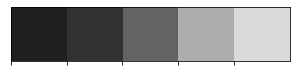

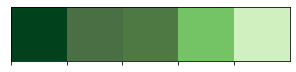

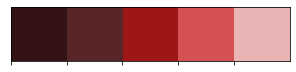

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

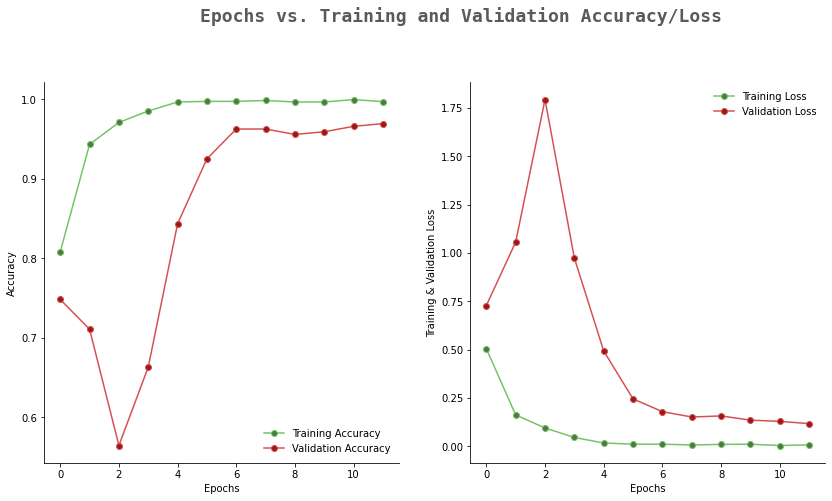

In [ ]:
filterwarnings('ignore')
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
fig.show()

In [ ]:

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.96      0.94      0.95        90
           2       0.96      0.98      0.97        96
           3       0.99      0.99      0.99        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



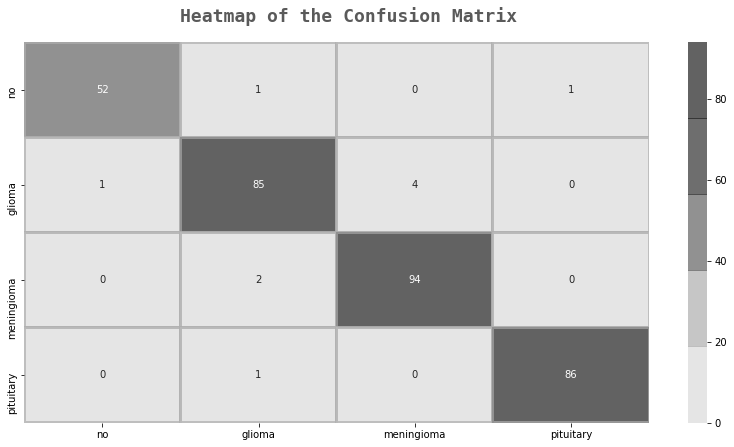

[[52  1  0  1]
 [ 1 85  4  0]
 [ 0  2 94  0]
 [ 0  1  0 86]]


In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_dark[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()
print(confusion_matrix(y_test_new,pred))